In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import numpy as np
import random

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


train_category_lines = {}
test_category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('../../content/drive/My Drive/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    nd = np.array(lines)
    print("Category {:10} | #names :{:5} | #unique names : {:5} | #redundancy names : {:5} | Redundancy rate {:.2f}%".format(category,len(lines),np.unique(nd).shape[0],
                                                                                    len(lines)-np.unique(nd).shape[0],100* (len(lines)-np.unique(nd).shape[0])/len(lines)))
    
    # Delete duplicated names
    lines = np.unique(nd).tolist()
    random.shuffle(lines)  # shuffle before a simple slicing
    train_category_lines[category] = lines[:int(len(lines)*0.9)] # Train data
    test_category_lines[category] = lines[int(len(lines)*0.9 ):] # Test data

n_categories = len(all_categories)

Category Irish      | #names :  232 | #unique names :   226 | #redundancy names :     6 | Redundancy rate 2.59%
Category Portuguese | #names :   74 | #unique names :    74 | #redundancy names :     0 | Redundancy rate 0.00%
Category Polish     | #names :  139 | #unique names :   138 | #redundancy names :     1 | Redundancy rate 0.72%
Category Chinese    | #names :  268 | #unique names :   246 | #redundancy names :    22 | Redundancy rate 8.21%
Category Italian    | #names :  709 | #unique names :   701 | #redundancy names :     8 | Redundancy rate 1.13%
Category English    | #names : 3668 | #unique names :  3668 | #redundancy names :     0 | Redundancy rate 0.00%
Category German     | #names :  724 | #unique names :   690 | #redundancy names :    34 | Redundancy rate 4.70%
Category Scottish   | #names :  100 | #unique names :   100 | #redundancy names :     0 | Redundancy rate 0.00%
Category French     | #names :  277 | #unique names :   273 | #redundancy names :     4 | Redundancy rat

In [2]:
print(all_categories)
print(n_categories)
print(train_category_lines['Italian'][:5])

['Irish', 'Portuguese', 'Polish', 'Chinese', 'Italian', 'English', 'German', 'Scottish', 'French', 'Czech', 'Greek', 'Japanese', 'Arabic', 'Korean', 'Spanish', 'Russian', 'Vietnamese', 'Dutch']
18
['Benenati', 'Abbadelli', 'Boveri', 'Maria', 'Landi']


In [3]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)


def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor
# OneHot Encoding Function Set
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [0]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size,hidden_size,1)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden,cell):
       
        input = input.expand(1,1,self.input_size)
        output,(hidden,cell) = self.lstm(input,(hidden,cell))
        output = self.decoder(output)
        output = self.softmax(output)
        output = output.view(1,-1)
        return output, hidden, cell

    def initHidden(self):
        
        return torch.zeros(1,1, self.hidden_size),torch.zeros(1,1,self.hidden_size)

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

In [0]:
input = letterToTensor('A')
hidden =torch.zeros(1,1, n_hidden)
cell = torch.zeros(1,1,n_hidden)
output, next_hidden,next_cell = lstm(input, hidden,cell)

In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1,1, n_hidden)
cell = torch.zeros(1,1, n_hidden)

output, next_hidden,next_cell = lstm(input[0], hidden,cell)
print(output)

tensor([[-2.8382, -2.9572, -2.8515, -2.8511, -2.9558, -2.8685, -2.9303, -2.9500,
         -2.8067, -2.8963, -2.8377, -2.9654, -2.8585, -2.9439, -2.8636, -2.8684,
         -2.9704, -2.8378]], grad_fn=<ViewBackward>)


In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 8)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomExample(category_lines):
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomExample(train_category_lines)
    print('category =', category, '/ line =', line)

category = Portuguese / line = Duarte
category = Scottish / line = Mckenzie
category = Scottish / line = Maclean
category = Czech / line = Ritchie
category = Japanese / line = Yasujiro
category = Russian / line = Halaev
category = Greek / line = Kouros
category = Vietnamese / line = Nguyen
category = Vietnamese / line = Ton
category = Scottish / line = Wilson


In [0]:
criterion = nn.NLLLoss()

In [0]:
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden,cell = lstm.initHidden()

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden,cell = lstm(line_tensor[i], hidden,cell)

    loss = criterion(output, category_tensor)
    loss.backward()

    
    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomExample(train_category_lines)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


5000 5% (0m 16s) 2.8035 Gwozdek / Polish ✓
10000 10% (0m 33s) 2.8276 Ma / Chinese ✗ (Vietnamese)
15000 15% (0m 49s) 2.8749 Vann / Irish ✗ (German)
20000 20% (1m 6s) 2.3935 Chepelyanov / Russian ✓
25000 25% (1m 22s) 2.0117 Lian / Korean ✗ (Chinese)
30000 30% (1m 39s) 3.3648 Lyon / Vietnamese ✗ (Dutch)
35000 35% (1m 56s) 1.7513 Peter / German ✓
40000 40% (2m 12s) 0.8259 Kringos / Greek ✓
45000 45% (2m 29s) 2.6569 Lomax / Arabic ✗ (English)
50000 50% (2m 45s) 2.7833 Ritchie / Irish ✗ (Czech)
55000 55% (3m 2s) 1.9601 Espinoza / Polish ✗ (Spanish)
60000 60% (3m 19s) 2.4586 Diaz / Arabic ✗ (Spanish)
65000 65% (3m 35s) 0.6783 Vistchinsky / Russian ✓
70000 70% (3m 52s) 0.0171 Makhankov / Russian ✓
75000 75% (4m 9s) 3.6069 Albert / French ✗ (Spanish)
80000 80% (4m 25s) 3.8045 Ba / Vietnamese ✗ (Arabic)
85000 85% (4m 42s) 1.5004 Gaertner / French ✗ (German)
90000 90% (4m 59s) 1.7957 Moulin / Irish ✗ (French)
95000 95% (5m 16s) 0.9203 Bei / Chinese ✓
100000 100% (5m 32s) 4.4699 See / Chinese ✗ (D

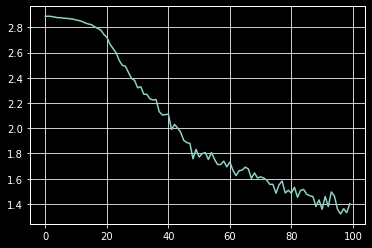

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('dark_background')
plt.figure()
plt.plot(all_losses)

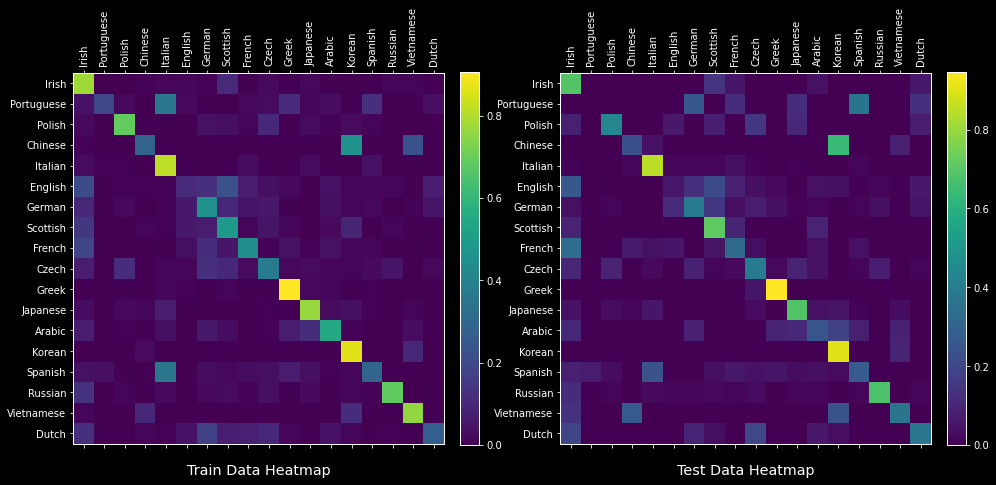

In [22]:

train_confusion = torch.zeros(n_categories, n_categories)
test_confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden,cell = lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden,cell = lstm(line_tensor[i], hidden,cell)

    return output


fig = plt.figure(figsize=(16,32))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for k,(ax,confusion,category_lines) in enumerate(zip([ax,ax2],[train_confusion,test_confusion],[train_category_lines,test_category_lines])):
        
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomExample(category_lines)
        output = evaluate(line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax,ax=ax,fraction=0.046,pad=0.04)

    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)


    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.grid(False)

    if k ==0:
        ax.set_title("Train Data Heatmap",position=(0.5,-0.1))
    else:
        ax.set_title("Test Data Heatmap",position=(0.5,-0.1))
plt.show()

In [25]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

    
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('James')
predict('Kuro')
predict('Hong')


> James
(-1.24) Dutch
(-1.90) English
(-2.09) German

> Kuro
(-0.62) Japanese
(-2.68) Korean
(-2.94) Arabic

> Hong
(-0.39) Korean
(-1.52) Chinese
(-2.97) Vietnamese
